# Image classification

Now you will build a network for classifying images in the CIFAR-10 dataset. You will do so using the Keras API, which, as you will see, makes the whole process _extremely_ simpler! (In fact, Tensorflow is officially adopting Keras as its standard API now with the launch of its version 2.0). But you don't really understand how TF works unless you've run it "bare-bones", so hopefully the previous tutorials were helpful to give you an idea of how the TF computation graph is implemented.

Acknowledgement: parts of this tutorial were adapted from the excellent tutorials in the [Hvass-Labs](https://github.com/Hvass-Labs/TensorFlow-Tutorials) page (highly recommended! also available on YouTube).

## Flowchart

The chart below shows the steps in the deep network that will be implemented in this tutorial. Our model will have two convolutional layers, two fully-connected layers and finally a softmax classification layer:

In [2]:
from IPython.display import Image
Image('Q4-model.png') #image created with http://alexlenail.me/NN-SVG/

## Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.disable_eager_execution()
import numpy as np
import time
import os

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten

Instructions for updating:
non-resource variables are not supported in the long term


## Load Data

The CIFAR-10 data-set is about 163 MB and will be downloaded if it is not already located in the  datasets path (~/.keras/datasets/).

In [15]:
from tensorflow.python.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data() #load dataset into ~/.keras/datasets/

#printout shapes of train and test data
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


__Q: How many traning and test examples are there? What shape is each image in the datset? How many different classes are there?__

In [16]:
max(y_train)

array([9], dtype=uint8)

In [17]:
#YOUR CODE/ANSWER HERE
N_train = 50000
N_test = 10000
img_shape = (32, 32, 3) #use a tuple in the fomat: (height, width, n_channels)
n_classes = 9

print(N_train,N_test,img_shape,n_classes)



50000 10000 (32, 32, 3) 9


__Q: Plot the first 5 training examples of each class as subplots in an__`n_classes` __-by-5 grid. Name each class and put your class names in a list__ `class_names`__.__

['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


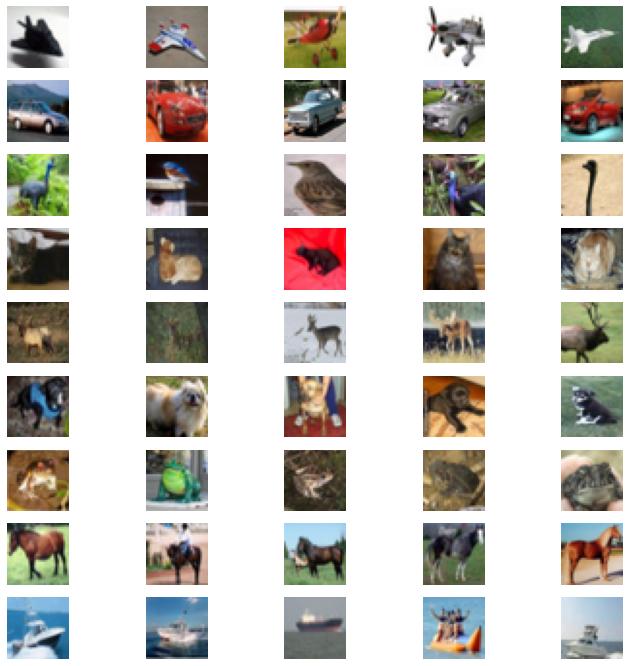

In [18]:
#YOUR CODE/ANSWER HERE
some_images = []
# #your plotting code here
for i in range(n_classes):
    count = 0
    index = 0
    count_total = 0
    while count < 5:
        if i  == y_train[index]:
            some_images.append(x_train[index])
            count += 1
        index += 1
        
fig, axs = plt.subplots(nrows = n_classes, ncols = 5, figsize = (12,12))
for i, ax in enumerate(axs.flatten()):
    img = some_images[i]
    ax.imshow(img, cmap = 'viridis')
    ax.axis('off')
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog','horse','ship','truck']
print (class_names)

__Now convert the class numbers in__ `y_train` __and__ `y_test` __into one-hot encoded arrays. Use the function__ `tf.keras.utils.to_categorical`__.__

*Hint:* run `?tf.keras.utils.to_categorical` in a separate notebook cell to open up the docs for this function, or simply hit `shift+tab` twice once your cursor is inside the parentheses in `tf.keras.utils.to_categorical(...)`.

In [8]:
?tf.keras.utils.to_categorical

In [19]:
#YOUR CODE/ANSWER HERE
y_train = tf.keras.utils.to_categorical(y_train,dtype='int')
y_test = tf.keras.utils.to_categorical(y_test,dtype='int')

In [20]:
y_test.shape

(10000, 10)

Now you will start building your network model. We will use the Sequential Model class for that. More info [here](https://keras.io/getting-started/sequential-model-guide/).

In [11]:
# Start construction of the Keras Sequential model.
model = Sequential()

# Input layer for setting the shape of the input images
model.add(InputLayer(input_shape=img_shape,))

# First convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=64, padding='same',
                 activation='relu', name='layer_conv1'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Second convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=64, padding='same',
                 activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten the 4-rank output of the convolutional layers
# to 2-rank that can be input to a fully-connected / dense layer.
model.add(Flatten())  
# First fully-connected / dense layer with ReLU-activation.
model.add(Dense(256, activation='relu'))

# Second fully-connected / dense layer with ReLU-activation.
model.add(Dense(128, activation='relu'))

# Last fully-connected / dense layer with softmax-activation
# for use in classification.
model.add(Dense(n_classes + 1, activation='softmax'))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv1 (Conv2D)         (None, 32, 32, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 16, 16, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1048832   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3

Learn more about Adam and other gradient descent-based methods here:
    http://ruder.io/optimizing-gradient-descent/index.html

In [13]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate = 1e-4) #lr sets the learning rate (default: .001)

The next step is compiling your model using the optimizer chosen above. You should set the loss function to be used, together with any metrics you might want computed after each training step. More info on metrics [here](https://keras.io/metrics/).

In [14]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Believe it or not, after these simple and intuitive steps, your network model is ready to be trained! Use the `fit` method, passing the inputs `x`, desired outputs `y`, and setting the number of `epochs` and `batch_size`. (Be careful: if you choose too large a batch size, your machine might get really slow if it runs short of RAM -- if that happens, simply choose smaller batches.)


In [ ]:
model.fit(x=x_train,
          y=y_train,
          epochs=4, batch_size=100)

Train on 50000 samples
Epoch 1/4
50000/50000 [==============================] - 272s 5ms/sample - loss: 2.6772 - acc: 0.3313
Epoch 2/4
50000/50000 [==============================] - 274s 5ms/sample - loss: 1.4483 - acc: 0.4865
Epoch 3/4
50000/50000 [==============================] - 272s 5ms/sample - loss: 1.2610 - acc: 0.5540
Epoch 4/4
45500/50000 [==========================>...] - ETA: 24s - loss: 1.1306 - acc: 0.5985

Another method available for the Sequential model class is `evaluate`. This runs your network in "test mode" without updating any weights (no backprop), while evaluating any metrics that have been set for the model.

In [17]:
result = model.evaluate(x=x_test,
                        y=y_test)
for name, value in zip(model.metrics_names, result):
    print(name, value)

10000/10000 [==============================] - 15s 2ms/sample - loss: 1.2286 - acc: 0.5722
loss 1.2286220457077026
acc 0.5722


That wasn't a great accuracy. Let's keep training it for a couple more epochs with larger batches and see if we can improve it:

In [18]:
#we don't start over: the training continues from the point where it stopped last time
model.fit(x=x_train,
          y=y_train,
          epochs=2, batch_size=150)

Train on 50000 samples
Epoch 1/2
50000/50000 [==============================] - 273s 5ms/sample - loss: 0.9768 - acc: 0.6572
Epoch 2/2
50000/50000 [==============================] - 272s 5ms/sample - loss: 0.8875 - acc: 0.6903


In [19]:
result = model.evaluate(x=x_test,
                        y=y_test)
for name, value in zip(model.metrics_names, result):
    print(name, value)

10000/10000 [==============================] - 15s 2ms/sample - loss: 1.1772 - acc: 0.5932
loss 1.1772324216842651
acc 0.5932


That is slightly better. Let's be happy with what we have for now and save out current trained model.

In [20]:
#This is how you save your model for later use. It will keep the current learned set of weights.
model_path = 'modelweights.keras'
model.save(model_path) #save the weights only -- 
# can reload them with model.load_weights(model_path) 

#This other option saves the entire model: layers + weights
from tensorflow.python.keras.models import save_model
model_path = 'fullmodel.keras'
save_model(model,model_path)

# (And this is how you load a previously saved model:)
# from tensorflow.python.keras.models import load_model
# model_path = 'fullmodel.keras'
# model = load_model(model_path)

Now let's take a look at what kinds of images the network wasn't able to correctly classify. we can use `predict` to get the network output for a given input set of images:

In [21]:
y_pred = model.predict(x=x_test)

In [22]:
y_pred

array([[6.38740091e-03, 3.23631940e-03, 1.35949897e-02, ...,
        4.51973174e-03, 1.66490600e-02, 3.03375185e-03],
       [1.95540837e-03, 6.78969085e-01, 1.07241995e-05, ...,
        1.66555935e-06, 2.47076735e-01, 7.18187615e-02],
       [4.72375304e-02, 8.52571204e-02, 1.50566571e-03, ...,
        1.53745245e-03, 6.10739529e-01, 2.48835161e-01],
       ...,
       [5.39005827e-03, 2.45261532e-07, 5.69178283e-01, ...,
        7.67620653e-02, 6.00477541e-03, 5.47884338e-06],
       [3.46728426e-04, 9.22532678e-01, 4.15088609e-03, ...,
        3.55089479e-03, 2.69210159e-05, 1.91111630e-03],
       [1.84835936e-03, 1.48365111e-03, 7.99656380e-03, ...,
        7.61641979e-01, 2.21237773e-03, 2.22370420e-02]], dtype=float32)

__Q: Plot 16 examples of images in the test set that are incorrectly classified. Label them by their true class and the class predicted by the network (use your__ `class_names` __list for naming the classes!). Use subplots on a 4-by-4 grid.__

In [23]:
# YOUR CODE HERE
'''
# Negate the boolean array.

    correct = (cls_true == cls_pred)
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                class_true=class_true[0:9],
                class_pred=class_pred[0:9])
    
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (12,12))
for i, ax in enumerate(axs.flatten()):
    img = incorrect
    _images[i]
    ax.imshow(img, cmap = 'viridis')
    ax.axis('off')
    '''

"\n# Negate the boolean array.\n\n    correct = (cls_true == cls_pred)\n    incorrect = (correct == False)\n    \n    # Get the images from the test-set that have been\n    # incorrectly classified.\n    images = images_test[incorrect]\n    \n    # Get the predicted classes for those images.\n    cls_pred = cls_pred[incorrect]\n\n    # Get the true classes for those images.\n    cls_true = cls_test[incorrect]\n    \n    # Plot the first 9 images.\n    plot_images(images=images[0:9],\n                class_true=class_true[0:9],\n                class_pred=class_pred[0:9])\n    \nfig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (12,12))\nfor i, ax in enumerate(axs.flatten()):\n    img = incorrect\n    _images[i]\n    ax.imshow(img, cmap = 'viridis')\n    ax.axis('off')\n    "

### Visualization of Layer Weights and Outputs

In order to access the layers in your network, it might be helpful to print out a summary of your model.

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv1 (Conv2D)         (None, 32, 32, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 16, 16, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1048832   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3

We count the indices to get the layers we want.
The first conv layer has index 0.

In [25]:
layer_conv1 = model.layers[0] 

The second convolutional layer has index 2.

In [26]:
layer_conv2 = model.layers[2] 

Once we have the layers, easily get to their current weights with `get_weights()`.

In [27]:
weights_conv1, bias_conv1 = layer_conv1.get_weights()

#alway check whether the shapes make sense!
weights_conv1.shape,bias_conv1.shape

((5, 5, 3, 64), (64,))

__Q: Get the weights the second conv layer now.__

In [28]:
# TODO
weights_conv2, bias_conv2 = layer_conv1.get_weights()

#alway check whether the shapes make sense!
weights_conv2.shape,bias_conv2.shape

((5, 5, 3, 64), (64,))

Note that the filters in the first conv layer have a non-unitary third dimension, due to the input images being color-images (3 channels: R,G,B). So, you can either plot each channel separately or combine the three into a color image: but you need to convert the values into integers within the range 0-255 (note that, for weights in the second layer, of course you only have the former option!).

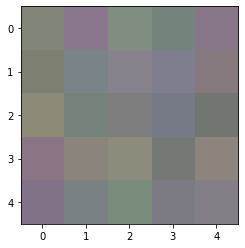

In [29]:
w = weights_conv1[:,:,:,0]
#find min and max vals
min_w, max_w = w.min(), w.max()
#put into 0-1 range, then scale by 255 and cast to unsigned int
w = (255*(w - min_w / (max_w - min_w))).astype('uint8')
plt.imshow(w)

__Q: Plot some of filters for the first and second conv layers.__

_(you can try setting `interpolation='gaussian'` in `imshow` to see if the appearance of the filters improve with a little blurring)_

Text(0.5, 0.98, 'Filters in Layer 2')

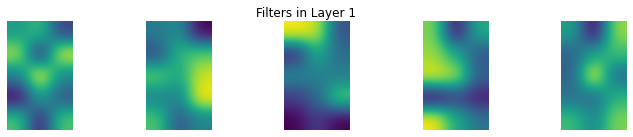

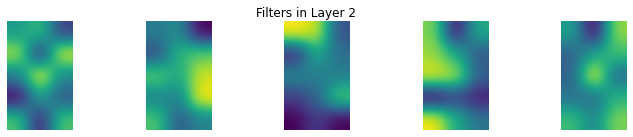

In [30]:
# YOUR CODE HERE
w2 = weights_conv2[:,:,:,0]
#find min and max vals
min_w2, max_w2 = w2.min(), w2.max()
#put into 0-1 range, then scale by 255 and cast to unsigned int
w2 = (255*(w2 - min_w2 / (max_w2 - min_w2))).astype('uint8')
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (12,2))
for i , ax in enumerate(axs.flatten()):
    img = w[i]
    ax.imshow(img,interpolation='gaussian')
    ax.axis('off')
fig.suptitle('Filters in Layer 1')

fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (12,2))
for i , ax in enumerate(axs.flatten()):
    img = w2[i]
    ax.imshow(img,interpolation='gaussian')
    ax.axis('off')
fig.suptitle('Filters in Layer 2')


### Plotting the output of a convolutional layer

For this, we will use the `K` backend function which will create a function from a part of your Keras model. (It's actually less complicated than it sounds!)

In [31]:
from tensorflow.python.keras import backend as K

#since layer_conv1 is the first real layer in our model (index 0),
# the input to layer_conv1 are the actual input images
output_conv1 = K.function(inputs=[layer_conv1.input], 
                          outputs=[layer_conv1.output])

In [32]:
#pick an image from the test set to feed it to the network
im1 = x_test[0]

#put the image inside a list since the layer expects a 4-d input tensor as input
out1 = output_conv1(np.array([im1]))[0] 
out1.shape

(1, 32, 32, 64)

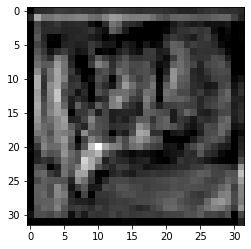

In [33]:
plt.imshow(out1[0,:,:,31],cmap='gray')

__Q: Plot some outputs for the second conv layer.__

Text(0.5, 0.98, 'Outputs for Layer 2')

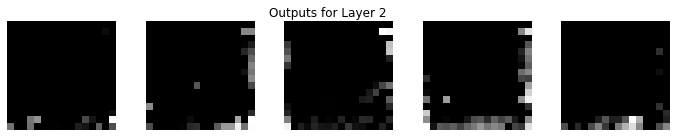

In [36]:
# YOUR CODE HERE
from tensorflow.python.keras import backend as K

output_conv2 = K.function(inputs=[layer_conv1.input], 
                          outputs=[layer_conv2.output])

fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (12,2))
for i , ax in enumerate(axs.flatten()):
    im = x_test[i]
    out  = output_conv2(np.array([im]))[0] 
    ax.imshow(out[0,:,:,31],cmap='gray')
    ax.axis('off')
fig.suptitle('Outputs for Layer 2')


### Compute maximally-activating images using Keras

The function below will compute max images in a very similar way to what was done in Q4, except now using the Keras backend. Make sure you understand it! We also use a separate function to convert the optimized input array into a reasonable image format.

In [37]:
from tensorflow.python.keras import backend as K

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    # (this trick helps to make it look like a "real" image)
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    # make sure pixel values are in the correct range
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def compute_max_image(input_img_placeholder,layer_output,
                      epochs=20,step=1.):
    loss = K.mean(layer_output)

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img_placeholder)[0]

    # normalization trick: normalizing the gradient with its root-mean-square
    # avoids very small and very large gradients and ensures a smooth gradient ascent process.
    grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon()) #RMS

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img_placeholder], [loss, grads])
    
    # we start from a gray image with some noise
    input_img_data = (np.random.random((1, img_shape[0], img_shape[1], img_shape[2]))-.5).astype(np.float32) * 20 + 128.
    
    # run gradient ascent for e.g. 20 steps
    for _ in range(epochs):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    # decode the resulting input image          
    img = input_img_data[0]
    img = deprocess_image(img)
    return loss_value,img

In [38]:
## Debugging note: .gradients is drepracted in TF2 using tfv1 instead
#Let's generate some max images for layer_conv1
mylayer = layer_conv1

filt_indices = range(16)
res = []
for filter_index in filt_indices:
    print(filter_index,end=" ")

    layer_output = mylayer.output[:, :, :, filter_index]
    
    input_img = model.inputs[0]

    loss, img = compute_max_image(input_img,layer_output)
    print(" loss:",loss)
    res.append(img)
    

0  loss: 17.971912
1  loss: 13.307876
2  loss: 7.910618
3  loss: 1.1514485
4  loss: 5.4544487
5  loss: 3.77867
6  loss: 10.39769
7  loss: 4.517516
8  loss: 1.5897093
9  loss: 14.642988
10  loss: 4.7430906
11  loss: 0.1999788
12  loss: 6.940923
13  loss: 0.50731355
14  loss: 13.456241
15  loss: 11.005785


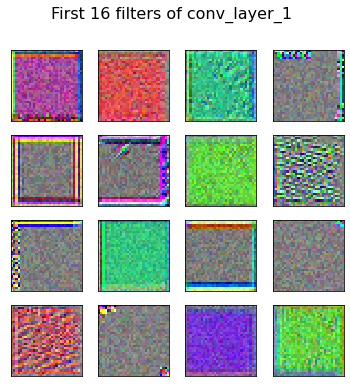

In [39]:
def plot_image_ax(image,ax):
    ax.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='gray')
r,c = 4,4
filt_indices = range(r*c)
f,axes = plt.subplots(r,c,figsize=(c*1.5,r*1.5))
f.subplots_adjust(wspace=.2,hspace=.2)
plt.suptitle('First 16 filters of conv_layer_1',size=16)
for ax_i,img in enumerate(res):
    ax = axes.ravel()[ax_i]
    plot_image_ax(img,ax)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()  

__Q. Plot maximally-activating images for generated layer_conv1. Do the same for layer_conv2. (Remember, none of these are unique, so by running the code again you might get different examples, corresponding to reaching different local maxima with gradient ascent.)__

0  loss: 17.975128
1  loss: 13.419697
2  loss: 7.9123793
3  loss: 1.1963052
4  loss: 5.476196
5  loss: 3.693644
6  loss: 10.320758
7  loss: 4.415713
8  loss: 1.4886236
9  loss: 14.644996
10  loss: 4.7456465
11  loss: 0.2253307
12  loss: 7.3800845
13  loss: 0.5436687
14  loss: 13.43583
15  loss: 10.973057
16  loss: 15.516405
17  loss: 20.463215
18  loss: 10.415598
19  loss: 65.3272
20  loss: 23.793087
21  loss: 1.7452021
22  loss: 5.0455995
23  loss: 8.18871
24  loss: 16.175407
25  loss: 7.163001
26  loss: 1.9138603
27  loss: 9.618649
28  loss: 27.017847
29  loss: 36.9684
30  loss: 2.463935
31  loss: 19.068125
32  loss: 31.997032
33  loss: 1.229725
34  loss: 9.033115
35  loss: 13.270446
36  loss: 3.2234628
37  loss: 13.441317
38  loss: 20.311201
39  loss: 2.5624995
40  loss: 32.635715
41  loss: 24.532875
42  loss: 8.366892
43  loss: 0.0
44  loss: 29.557999
45  loss: 8.035854
46  loss: 0.6284615
47  loss: 34.063637
48  loss: 0.72696817
49  loss: 17.405579


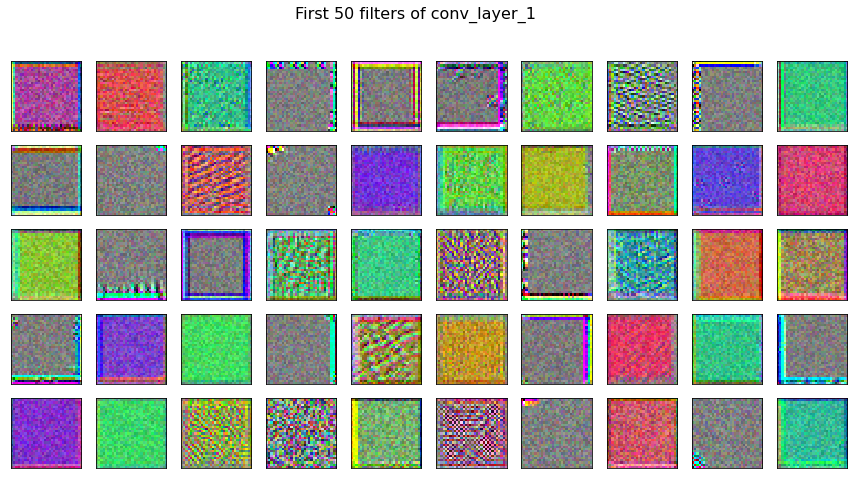

In [43]:
# YOUR CODE HERE

mylayer = layer_conv1

filt_indices = range(50)
res = []
for filter_index in filt_indices:
    print(filter_index,end=" ")

    layer_output = mylayer.output[:, :, :, filter_index]
    
    input_img = model.inputs[0]

    loss, img = compute_max_image(input_img,layer_output)
    print(" loss:",loss)
    res.append(img)

def plot_image_ax(image,ax):
    ax.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='gray')
r,c = 5,10
filt_indices = range(r*c)
f,axes = plt.subplots(r,c,figsize=(c*1.5,r*1.5))
f.subplots_adjust(wspace=.2,hspace=.2)
plt.suptitle('First 50 filters of conv_layer_1',size=16)
for ax_i,img in enumerate(res):
    ax = axes.ravel()[ax_i]
    plot_image_ax(img,ax)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()  

0  loss: 0.8952808
1  loss: 7.6517305
2  loss: 1.537722
3  loss: 0.65643775
4  loss: 4.107406
5  loss: 5.1854362
6  loss: 1.2655175
7  loss: 5.64222
8  loss: 7.831335
9  loss: 2.0734658
10  loss: 1.8665199
11  loss: 3.757595
12  loss: 3.9966946
13  loss: 1.3227565
14  loss: 3.033884
15  loss: 0.4345272
16  loss: 1.0822197
17  loss: 0.0
18  loss: 0.38395286
19  loss: 1.3449283
20  loss: 10.12888
21  loss: 0.0
22  loss: 1.6240238
23  loss: 2.1314273
24  loss: 2.6289592
25  loss: 1.3754513
26  loss: 4.0478134
27  loss: 0.7020102
28  loss: 2.041329
29  loss: 0.0
30  loss: 7.14027
31  loss: 3.418167
32  loss: 0.7125696
33  loss: 0.8829415
34  loss: 2.7646906
35  loss: 20.164825
36  loss: 0.0
37  loss: 2.1237078
38  loss: 1.8272095
39  loss: 0.8740282
40  loss: 0.74415624
41  loss: 1.1698055
42  loss: 5.4357924
43  loss: 2.270904
44  loss: 2.4770107
45  loss: 0.6937213
46  loss: 0.70961
47  loss: 9.152708
48  loss: 9.758505
49  loss: 2.4620242


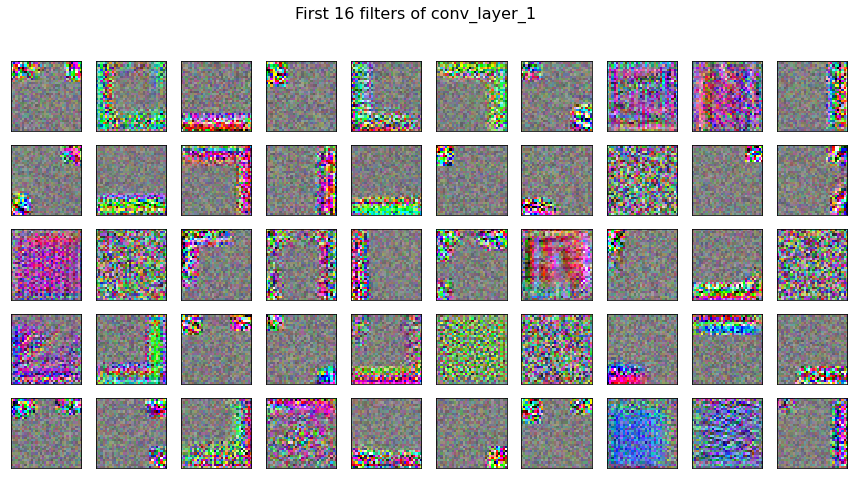

In [44]:
# YOUR CODE HERE

mylayer = layer_conv2

filt_indices = range(50)
res = []
for filter_index in filt_indices:
    print(filter_index,end=" ")

    layer_output = mylayer.output[:, :, :, filter_index]
    
    input_img = model.inputs[0]

    loss, img = compute_max_image(input_img,layer_output)
    print(" loss:",loss)
    res.append(img)

def plot_image_ax(image,ax):
    ax.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='gray')
r,c = 5,10
filt_indices = range(r*c)
f,axes = plt.subplots(r,c,figsize=(c*1.5,r*1.5))
f.subplots_adjust(wspace=.2,hspace=.2)
plt.suptitle('First 16 filters of conv_layer_1',size=16)
for ax_i,img in enumerate(res):
    ax = axes.ravel()[ax_i]
    plot_image_ax(img,ax)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()  

## Finding an input that maximizes a specific class

__Q. Now generate maximal images for each class (optimize the final output of the network, as you did in Q4).__

In [ ]:
# YOUR CODE HERE

__Q. _OPTIONAL:_ This [post](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html) from the Keras blog shows a more sofisticated strategy for generating maximal images, where we start with a small image and slowly grow its dimensions until it reaches the actual size. Feel free to use their code and see if you get better images. A heads up: you will need to change the input_shape of your Input layer to allow for variable-sized images (simply use__ `None`__),.__

In [51]:
# Start construction of the Keras Sequential model.
model_alt = Sequential()

# Input layer for setting the shape of the input images
model_alt.add(InputLayer(input_shape=img_shape,))

# First convolutional layer with ReLU-activation and max-pooling.
model_alt.add(Conv2D(kernel_size=5, strides=1, filters=64, padding='same',
                 activation='relu', name='layer_conv1'))
model_alt.add(MaxPooling2D(pool_size=2, strides=2))

# Second convolutional layer with ReLU-activation and max-pooling.
model_alt.add(Conv2D(kernel_size=5, strides=1, filters=64, padding='same',
                 activation='relu', name='layer_conv2'))
model_alt.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten the 4-rank output of the convolutional layers
# to 2-rank that can be input to a fully-connected / dense layer.
model_alt.add(Flatten())  
# First fully-connected / dense layer with ReLU-activation.
model_alt.add(Dense(256, activation='relu'))

# Second fully-connected / dense layer with ReLU-activation.
model_alt.add(Dense(128, activation='relu'))

# Last fully-connected / dense layer with softmax-activation
# for use in classification.
model_alt.add(Dense(n_classes + 1, activation='softmax'))


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# The dimensions of our input image
img_width = 180
img_height = 180
# img_width = 32
# img_height = 32
# Our target layer: we will visualize the filters from this layer.
# See `model.summary()` for list of layer names, if you want to change this.
layer_name = "conv3_block4_out"
#layer_name = "layer_conv2"

In [3]:
pip install tensorflow h5py<3.0.0

Note: you may need to restart the kernel to use updated packages.


The system cannot find the file specified.


In [3]:
# Build a ResNet50V2 model loaded with pre-trained ImageNet weights
model = keras.applications.ResNet50V2(weights= 'imagenet', include_top=False)

# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [5]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

In [6]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    #img = deprocess_image(img[0])
    img = deprocess_image(img[0].numpy())
    return loss, img

def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [ ]:
from IPython.display import Image, display

loss, img = visualize_filter(0)
keras.preprocessing.image.save_img("0.png", img)

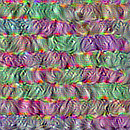

In [8]:
display(Image("0.png"))